In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys
from copy import deepcopy

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from utils import get_gaussian_kernel
from utils import convolve
from utils import convolve_pixel


## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

## 1. Space-variant blurring

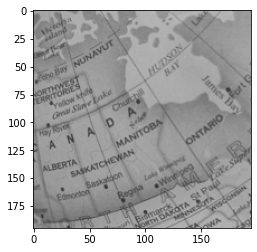

In [2]:
# Read input image.
img = cv.imread('data/input/globe.png')
bwimg = BWImage(img)
N = img.shape[0]
plt.imshow(img)

### Solve for A and B

By taking log on the distribution of $\sigma$ we get
$$\ln(\sigma(m, n)) = \ln(A) + \frac{-r(m, n)}{B}$$
where $r = (m - N/2)^2 + (n - N/2)^2$.

We are also give the value of $\sigma$ for two different lcoations. This gives rise to a system of linear equation which can be solved to the get the values of $A$ and $B$.

In [3]:
## Define some useful functions

def get_r(m, n):
    return ((m - N / 2)**2 + (n - N / 2)**2) # N is a global var and is determined above.

def get_sigma(m, n, A, B):
    return A * np.exp(-1 * get_r(m, n)/B)

In [4]:
## Solve the system of linear equations
coeffs = np.array([[1, -1 * get_r(N/2, N/2)], [1, -1 * get_r(0, 0)]])
consts = np.array([np.log(2), np.log(0.01)])
x, y = np.linalg.solve(coeffs, consts)
A = np.exp(x)
B = 1/y

In [5]:
# Print A and B and verify the solution.
print(A, B)
print(get_sigma(N/2, N/2, A, B))
print(get_sigma(0, 0, A, B))

2.0 3588.403390110064
2.0
0.010000000000000004


### Perform space-variant blurring

In [6]:
bwimg_blur = deepcopy(bwimg)
bwimg_blur.make_blank()
for i in range(N):
    for j in range(N):
        sigma = get_sigma(i, j, A, B)
        kernel = get_gaussian_kernel(sigma)
        bwimg_blur[i, j] = convolve_pixel((i, j), bwimg, kernel)

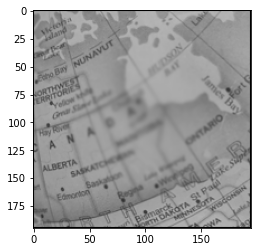

In [7]:
plt.imshow(bwimg_blur.get_image())

## 2. Blur Nautilus

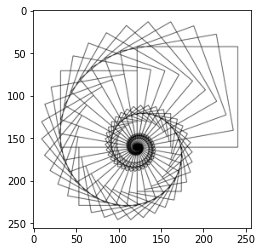

In [9]:
img = cv.imread('data/input/nautilus.png')
bwimg = BWImage(img)
N = img.shape[0]
plt.imshow(img)

In [10]:
space_invariant_kernel = get_gaussian_kernel(1.0)
bwimg_blur_space_invariant = convolve(bwimg, space_invariant_kernel)

100%|██████████| 250/250 [00:00<00:00, 506.29it/s]


In [21]:
# Change sigma definition.
def get_sigma(m, n, A, B):
    return 1.0

bwimg_blur_space_variant = deepcopy(bwimg)
bwimg_blur_space_variant.make_blank()
for i in range(N):
    for j in range(N):
        sigma = get_sigma(i, j, A, B)
        kernel = get_gaussian_kernel(sigma)
        # Use offset to translate to match the coordinates of two images
        # arising from space-variant blurring and space-invariant blurring.
        offset = int(kernel.shape[0] // 2)
        bwimg_blur_space_variant[i, j] = convolve_pixel((i + offset, j + offset), bwimg, kernel)

Text(0.5, 1.0, 'Space-variant blur')

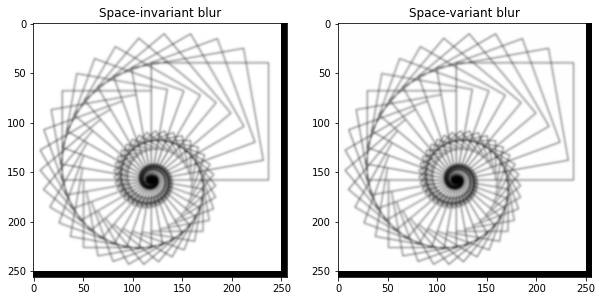

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(bwimg_blur_space_invariant.get_image())
ax[0].set_title('Space-invariant blur')
ax[1].imshow(bwimg_blur_space_variant.get_image())
ax[1].set_title('Space-variant blur')